# Bayesian Model
Priors:
- probability of preverbal negation -> binomial distribution
- probability of postverbal negation -> binomial distribution

=> Together they form **beta-binomial distribution** which defines the prior (see Reali & Griffiths for a beta-binomial model of language).

Additional factors:
- presence of negation (like unambiguity in Kirby's model of compositionality)
- error probability (can check same model) 

=> **Dirichlet multinomial model**

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Prior

Define an agent's belief before seing any data based on two parameters: (1) the probability of using preverbal negation, and (2) the probability of using postverbal negation:
$$\theta = (\theta_{pre}, \theta_{post})$$ 

The prior is thus drawn from a beta-binomial distribution: 
$$\theta \sim \text{Beta}(\alpha_{pre}, \alpha_{post}).$$

Agents sample $\theta$ from this prior and produce utterances accordingly.

In [128]:
# binary case: preverbal vs postverbal
def sample_theta_beta(alpha_pre, beta_post):
    """Sample theta from a Beta prior distribution. 
    
    Args:
        alpha_pre (float): Alpha parameter for preverbal negation (number of preverbal negations in data + 1).
        beta_post (float): Beta parameter for postverbal negation (number of postverbal negations in data + 1).
    
    Returns:
        float: Sampled value of theta from the Beta distribution.
    """
    return np.random.beta(alpha_pre, beta_post)

samples = [sample_theta_beta(0.8, 0.2) for _ in range(1000)]  # 80% preverbal, 20% postverbal
np.mean(samples), np.std(samples)

(np.float64(0.7993568538414265), np.float64(0.2874919708681391))

Adding a requirement for efficiency, i.e., using fewer negators. This will be a third parameter specifying the probability of two negation markers.

In [144]:
# multinomial case: 3 categories
def sample_theta_dirichlet(alpha_vec):
    """Sample theta from a Dirichlet prior distribution.
    Args:
        alpha_vec (list or np.array): Alpha parameters for the Dirichlet distribution.
    
    Returns:
        np.array: Sampled vector of theta from the Dirichlet distribution.
    """
    return np.random.dirichlet(alpha_vec)

sample_theta_dirichlet([0.8, 0.2, 1])  # Uniform distribution over 3 categories

array([0.29728749, 0.00956318, 0.69314933])

# Production

In [130]:
def produce_data(theta, n, noise=0.0):
    """Produce data based on sampled theta and noise.
    
    Args:
        theta (list or np.array): Probabilities for preverbal and postverbal negation.
        n (int): Number of utterances to generate.
        noise (float): Noise level to add to the theta probabilities. Default is 0.0 (no noise).
    
    Returns:
        np.array: A vector of counts for each category, sampled from a noisy multinomial distribution.
    """
    theta = np.array(theta)
    k = len(theta)
    # With probability `noise`, the utterance is drawn from a uniform distribution instead of the agent's true hypothesis, to simulate a random error.
    theta_noisy = (1 - noise) * theta + noise * (1.0 / k)
    # NOTE (TODO): is the noise really uniform? Or hould it be drawn from some other distribution?
    return np.random.multinomial(n, theta_noisy)

produce_data([0.7, 0.3], 1000, noise=0.1) 

array([697, 303], dtype=int32)

# Learning

Agents update their beliefs using Bayes' Rule: $$P(\theta | \text{data}) \propto P(\text{data}|\theta) P(\theta)$$

For a beta-binomial: $$\theta | \text{data} \sim \text{Beta} (\alpha_{pre} + n_{pre}, \alpha_{post} + n_{post})$$
where $n$ is the number of utterances generated based on $\theta$.

In [131]:
def update_posterior_beta(n_pre, n_post, alpha_pre, alpha_post):
    """Update the posterior distribution using Beta-Binomial.
    Args:
        n_pre (int): Count of preverbal negation utterances.
        n_post (int): Count of postverbal negation utterances.
        alpha_pre (float): Alpha parameter for preverbal negation prior.
        alpha_post (float): Alpha parameter for postverbal negation prior.
    
    Returns:
        tuple: Updated alpha parameters for preverbal and postverbal negation.
    """
    return alpha_pre + n_pre, alpha_post + n_post

def update_posterior_dirichlet(counts, alpha_vec):
    """Update the posterior distribution using Dirichlet-Multinomial.
    
    Args:
        counts (np.array): Counts of utterances for each category.
        alpha_vec (list or np.array): Alpha parameters for the Dirichlet prior.
    
    Returns:
        np.array: Updated alpha parameters for the Dirichlet posterior.
    """
    return alpha_vec + counts

# Plot theta samples (binary case)
def plot_theta_trajectory(theta_trajectory):
    plt.figure(figsize=(8, 5))
    theta_trajectory = np.array(theta_trajectory)
    plt.plot(theta_trajectory[:, 0], label='p(preverbal)')
    plt.plot(theta_trajectory[:, 1], label='p(postverbal)')
    plt.xlabel("Generation")
    plt.ylabel("Probability")
    plt.title("Trajectory of Theta Over Generations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Iterated learning

In [132]:
# Run iterated learning (binary)
def iterated_learning_binary(alpha_pre, alpha_post, generations=100, n=100, noise=0.1):
    theta_trajectory = []
    for gen in range(generations):
        theta = sample_theta_beta(alpha_pre, alpha_post)
        theta_trajectory.append([theta, 1 - theta])
        data = produce_data([theta, 1 - theta], n, noise)
        alpha_pre, alpha_post = update_posterior_beta(data[0], data[1], alpha_pre, alpha_post)
    return theta_trajectory

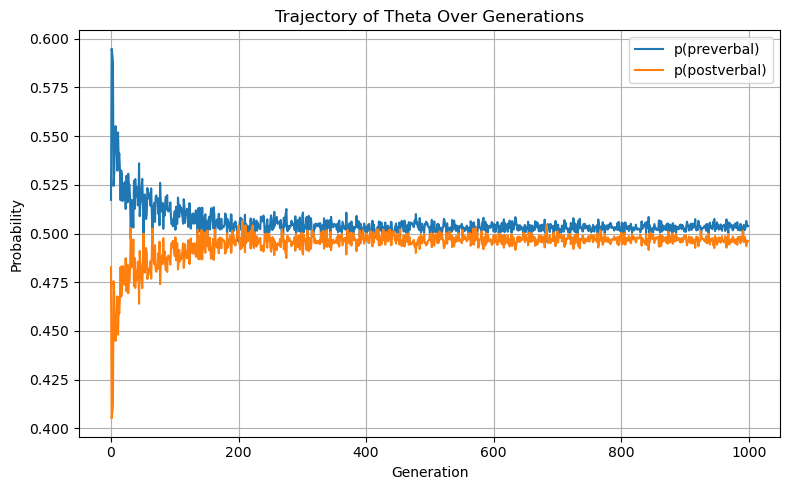

In [133]:
trajectory_binary = iterated_learning_binary(alpha_pre=0.8, alpha_post=0.2, generations=1000, n=100, noise=0.3)
plot_theta_trajectory(trajectory_binary)